In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

## Loading data
First we have to load data from the various tab-separated files

In [2]:
path = 'data/raw/'
df = pd.DataFrame()
df_list = [pd.read_csv(path + file ,sep='\t',header=None) for file in os.listdir(path)]
df = pd.concat(df_list)


In [3]:
df.columns = ['date', 'time', 'code', 'value']

## Data description
The data set contains a diabetes patient record
Columns:
1. date
2. time
3. code describes (#TODO)
4. value (#TODO)

Codes can be lookuped in a second dataframe (df_codes)

In [4]:
df.head()

,date,time,code,value
0,05-20-1991,08:00,58.0,101
1,05-20-1991,08:00,33.0,5
2,05-20-1991,08:00,34.0,27
3,05-20-1991,12:00,60.0,89
4,05-20-1991,12:00,33.0,3


In [5]:
df.isnull().any()

date     True
time     True
code     True
value    True
dtype: bool

We have null values in every column

In [6]:
nan_rows_date = df[df['date'].isnull()]
nan_rows_time = df[df['time'].isnull()]
nan_rows_code = df[df['code'].isnull()]
nan_rows_value = df[df['value'].isnull()]
print(f'nulls in date: {len(nan_rows_date)}')

nulls in date: 34


In [7]:
before = len(df)
df_clean = df.dropna()
after = len(df_clean)
print(f'removed {before-after} entries, length dataframe without null: {after}')

removed 67 entries, length dataframe without null: 29264


In [8]:
df_clean.isnull().any()

date     False
time     False
code     False
value    False
dtype: bool

We still have unclean data in the target column. Next step is to check them out and if necessary, remove them.

In [10]:
df_clean.loc[pd.to_numeric(df_clean['value'], errors='coerce').notnull()==False]

,date,time,code,value
74,11-06-1989,11:00,57.0,0''
169,10-31-1989,12:00,60.0,0Hi
203,11-04-1989,18:00,62.0,0Hi
209,11-05-1989,12:00,60.0,0Hi
217,11-06-1989,12:00,60.0,0Hi
221,11-06-1989,22:00,48.0,0Hi
235,11-08-1989,18:00,62.0,0Lo
611,12-25-1989,22:00,48.0,0Hi


### descriptive analysis, cleansing and outliers

#### General statistics and correlations

In [11]:
print(f'Amount data points: {len(df)}')

Amount data points: 29331


#### Date statistics

In [12]:
amount_dates = df['date'].nunique()
print(f'Amount days (uncleaned): {amount_dates}')

Amount days (uncleaned): 1141


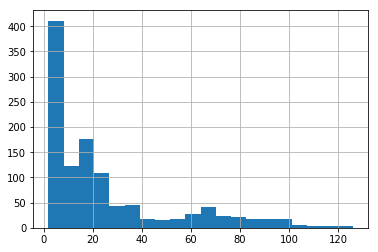

In [13]:
df.groupby('date').size().hist(bins=20)

In [14]:
min_per_day = df.groupby('date').size().min()
max_per_day = df.groupby('date').size().max()
print(f'Min. data points per day: {min_per_day}')
print(f'Min. data points per day: {max_per_day}')
print(df.groupby('date').size().describe(percentiles=[.75,.80,.95,.99]))

Min. data points per day: 2
Min. data points per day: 126
count    1141.000000
mean       25.676599
std        26.557611
min         2.000000
50%        16.000000
75%        31.000000
80%        42.000000
95%        86.000000
99%       106.200000
max       126.000000
dtype: float64


### data set description
1. The amount of data points per day is right-skewed -> 75% of days have less than 31, the remaining days hold between 32 and max 126 points
2. 

#### Time statistics

In [15]:
amount_times = df['time'].nunique()
print(f'Amount unique points in time (uncleaned): {amount_times}')

Amount unique points in time (uncleaned): 1311


#### Code statistics

In [16]:
amount_codes = df['code'].nunique()
print(f'Amount unique points in code (uncleaned): {amount_codes}')

Amount unique points in code (uncleaned): 24


#### Value statistics

In [17]:
amount_values = df['value'].nunique()
print(f'Amount unique points in value (uncleaned): {amount_values}')

Amount unique points in value (uncleaned): 744


# Classification


## Transformation and feature engineering

When Should I Use Log Transformation?
Many possible transformations exist. However, you should only use a log transformation if:

Your data is highly skewed to the right (i.e. in the positive direction).
(https://www.statisticshowto.datasciencecentral.com/probability-and-statistics/skewed-distribution/)

In [18]:
from sklearn.metrics import precision_recall_curve
y_train = [1]
y_scores = [1]
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

In [19]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

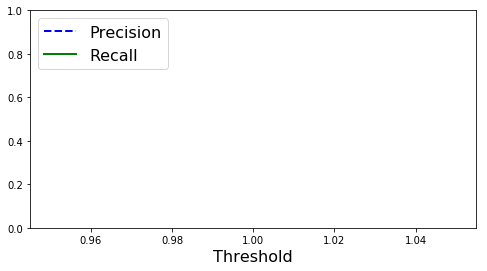

In [22]:
plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()